In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"

In [3]:
df = pd.read_pickle(RESAMPLED_FILE_PATH)
df.head()

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df.set_index('timestamp')

df.head()

,open,high,low,close,volume,spread
timestamp,,,,,,
2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667
2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333
2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667
2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857
2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100


## Datetime conversion

Dukascopy use UTC timezone

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

df

## Data Exloration

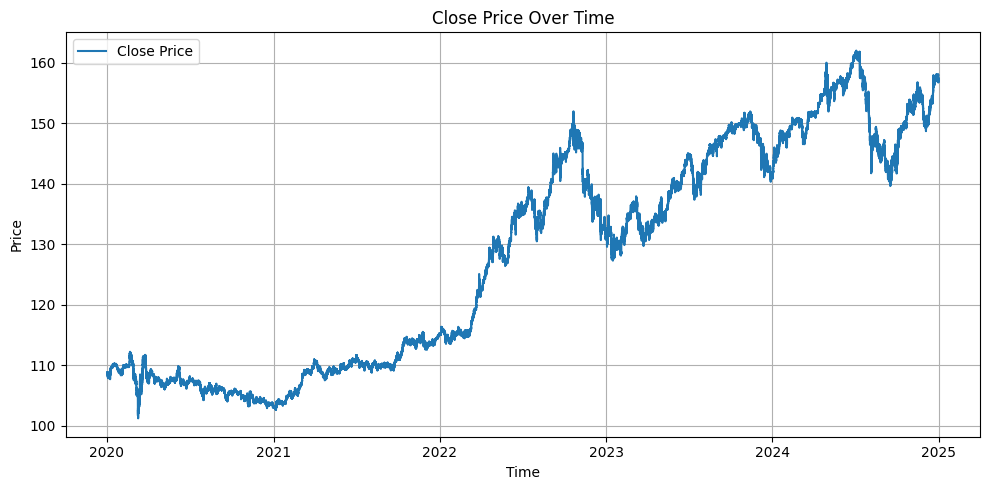

In [5]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close'], label='Close Price')

plt.title('Close Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


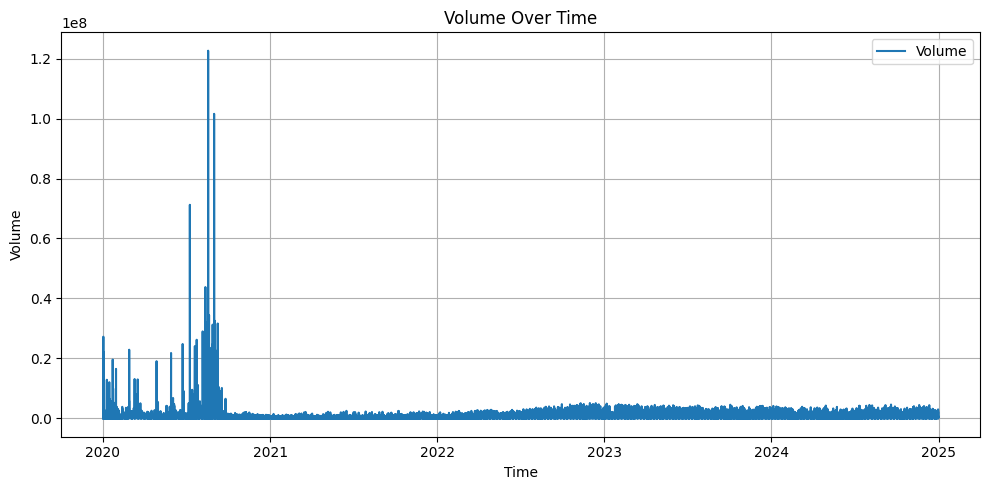

In [6]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and 'timestamp' is datetime type
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['volume'], label='Volume')

plt.title('Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df.isna().sum() / df.shape[0]

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
spread    0.0
dtype: float64

# Volume Feature Engineering

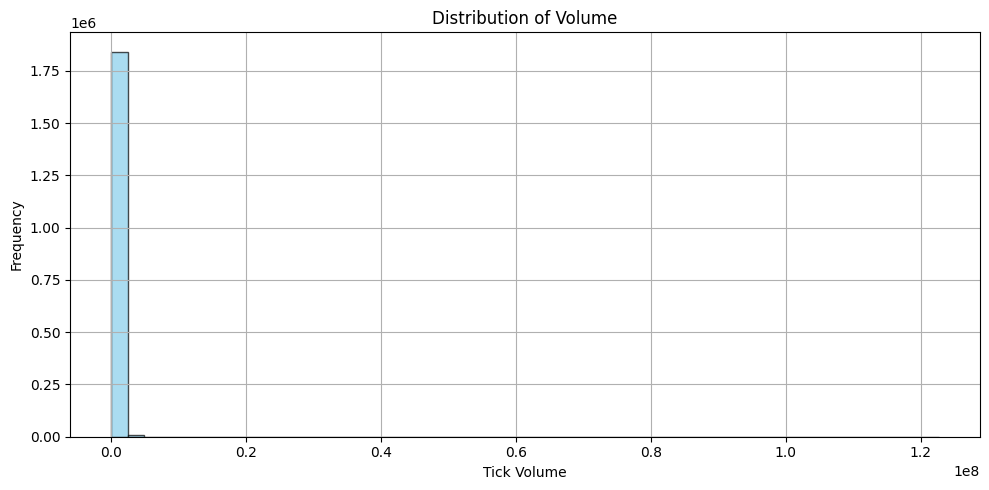

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Tick Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
df['log_volume'] = np.log1p(df['volume'])

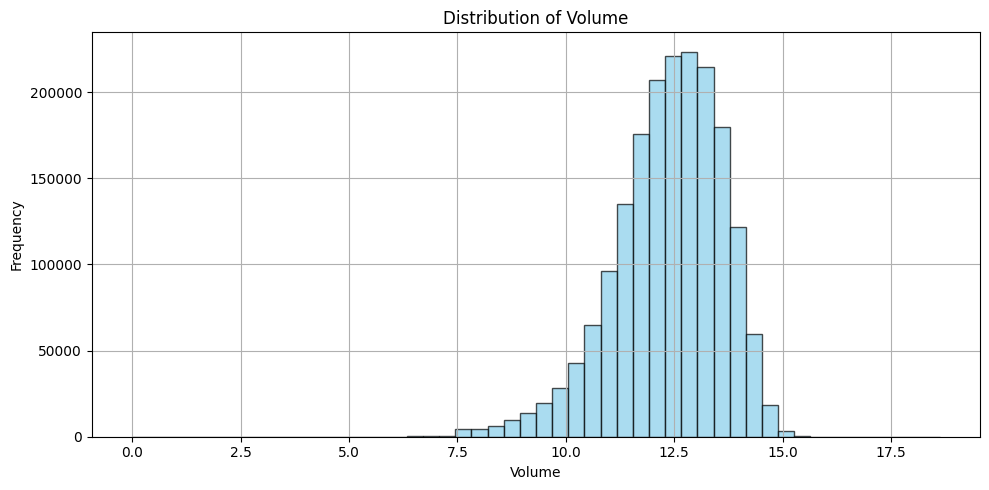

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['log_volume'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')

plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [11]:
import pandas as pd
import numpy as np

def add_return_features(df: pd.DataFrame, price_col: str = 'close') -> pd.DataFrame:
    """
    Adds delta, simple return, and log return columns based on a single price column.

    Args:
        df (pd.DataFrame): Input DataFrame with a price column.
        price_col (str): Column name containing price values (default = 'close').

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - {price_col}_delta
            - {price_col}_return
            - {price_col}_log_return
    """
    df = df.copy()
    df[f"{price_col}_delta"] = df[price_col] - df[price_col].shift(1)
    df[f"{price_col}_return"] = df[price_col] / df[price_col].shift(1) - 1
    df[f"{price_col}_log_return"] = np.log(df[price_col] / df[price_col].shift(1))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df


In [12]:
df = add_return_features(df)

## Plot histgram

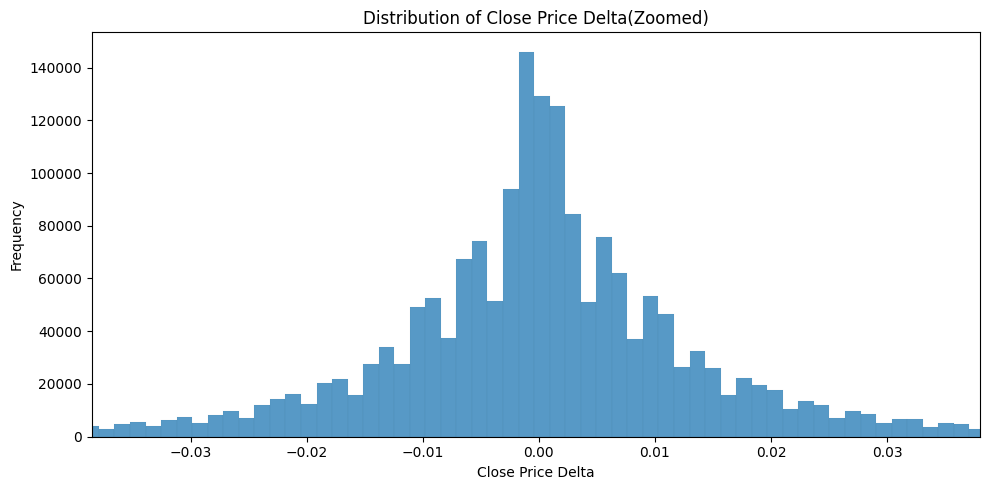

In [13]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

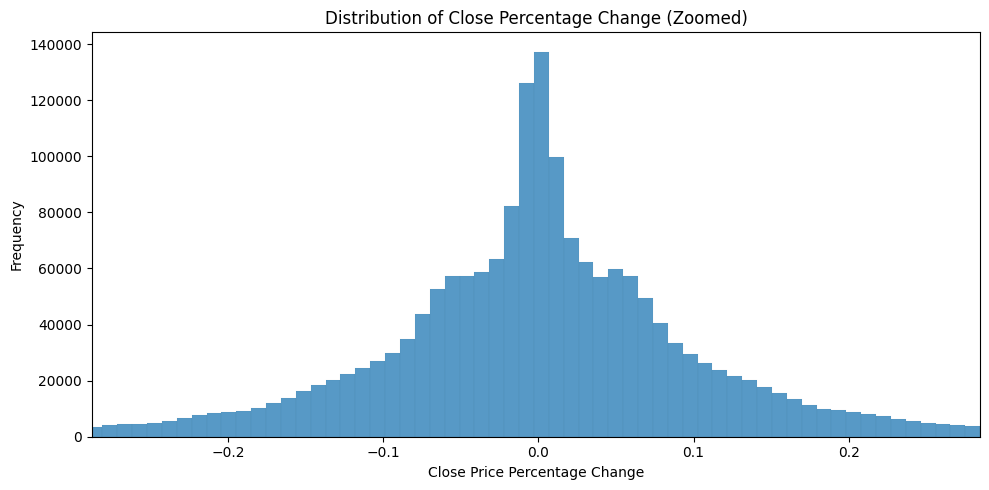

In [14]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

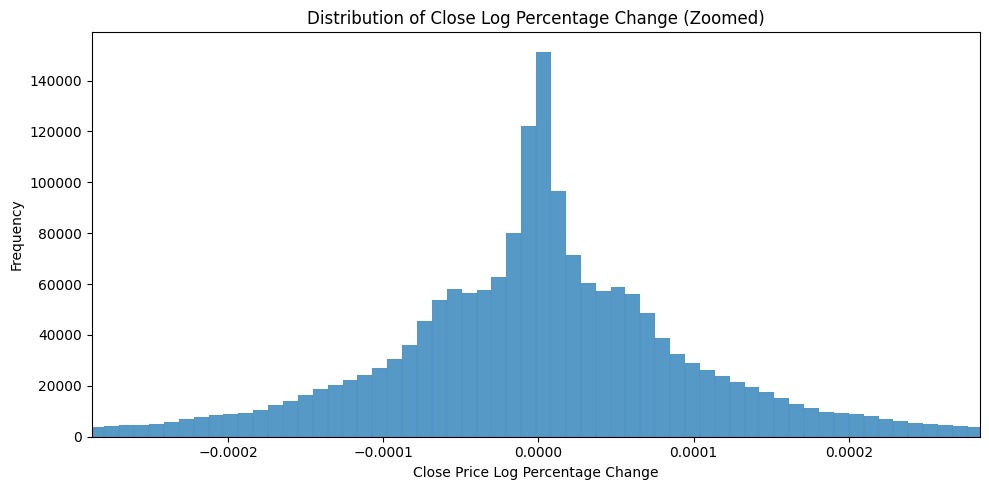

In [15]:
df_copy = df.copy()

low, high = (df_copy['close_log_return']).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_log_return'])
plt.title("Distribution of Close Log Percentage Change (Zoomed)")
plt.xlabel("Close Price Log Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

## Calculate average values

df['ma_21'] = (
    df['close']
    .rolling(window=21, min_periods=1)
    .mean()
)
df.head()

In [16]:
df['ret_mean_5'] = (
    df['close_log_return']
    .rolling(window=5, min_periods=5)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5
timestamp,,,,,,,,,,,
2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667,9.124891,NaN,NaN,NaN,NaN
2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333,9.495595,-0.0095,-0.000087,-0.000087,NaN
2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667,8.412055,0.0040,0.000037,0.000037,NaN
2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857,9.258273,0.0020,0.000018,0.000018,NaN
2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100,9.358847,0.0095,0.000087,0.000087,NaN


In [17]:
df['ret_mean_10'] = (
    df['close_log_return']
    .rolling(window=10, min_periods=10)
    .mean()
)
df.head()

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667,9.124891,NaN,NaN,NaN,NaN,NaN
2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333,9.495595,-0.0095,-0.000087,-0.000087,NaN,NaN
2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667,8.412055,0.0040,0.000037,0.000037,NaN,NaN
2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857,9.258273,0.0020,0.000018,0.000018,NaN,NaN
2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100,9.358847,0.0095,0.000087,0.000087,NaN,NaN


## Drop NaN

In [18]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
volume               0
spread               0
log_volume           0
close_delta          1
close_return         1
close_log_return     1
ret_mean_5           5
ret_mean_10         10
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df

,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,ret_mean_5,ret_mean_10
timestamp,,,,,,,,,,,,
2020-01-01 22:10:00,108.7455,108.7480,108.7430,108.7450,145529.998422,0.018840,11.888144,-0.0010,-0.000009,-0.000009,-4.597384e-05,-0.000013
2020-01-01 22:11:00,108.7445,108.7470,108.7395,108.7400,56379.999280,0.022235,10.939887,-0.0050,-0.000046,-0.000046,-3.126480e-05,-0.000009
2020-01-01 22:12:00,108.7340,108.7600,108.7340,108.7575,95219.999909,0.020086,11.463956,0.0175,0.000161,0.000161,-1.320558e-17,0.000004
2020-01-01 22:13:00,108.7600,108.7600,108.6495,108.7475,233979.999036,0.030118,12.362995,-0.0100,-0.000092,-0.000092,-1.287344e-05,-0.000007
2020-01-01 22:14:00,108.7455,108.7475,108.7445,108.7450,139499.999642,0.034500,11.845827,-0.0025,-0.000023,-0.000023,-1.839157e-06,-0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:55:00,157.0100,157.0110,157.0075,157.0080,206939.997196,0.011818,12.240189,-0.0045,-0.000029,-0.000029,1.656035e-05,-0.000016
2024-12-30 23:56:00,157.0075,157.0090,157.0075,157.0075,127200.000405,0.010920,11.753524,-0.0005,-0.000003,-0.000003,1.337560e-05,0.000008
2024-12-30 23:57:00,157.0035,157.0095,156.9900,157.0070,234090.000987,0.007978,12.363465,-0.0005,-0.000003,-0.000003,1.210174e-05,0.000014


# Saving the file

In [21]:
df.to_pickle(PROCESSED_FILE_PATH)